# Метод обратного распространения ошибок


---


Материал подготовлен с использованием статьи: https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/


   Рассмотрим простую нейронную сеть, которая представляет из себя 
*   2 входных нейрона
*   2 скрытых нейрона
*   2 выходных нейрона
*   2 нейрона смещения (на каждый слой по одному)

![alt text](https://matthewmazur.files.wordpress.com/2018/03/neural_network-7.png)

   
 

Рассмотрим проход по сети сигнала (0.05, 0.10), а потом произведем переинициализацию весов сети методом обратного распространения ошибки, опираясь на то, что выходным значением является (0.01,0.99). Зафиксируем начальные веса нейронов значениями, указанными на картинке снизу.
![alt text](https://matthewmazur.files.wordpress.com/2018/03/neural_network-9.png)

# Пишем нейронную сеть с функциями прямого распространения сигнала и обратного распространения ошибки

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def print_formula(tex):
  '''
    Рисуем формулы при выводе print().
  '''
  ### Создание области отрисовки
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_axis_off()

  ### Отрисовка формулы
  t = ax.text(0.5, 0.5, tex,
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=20, color='black')
  ### Определение размеров формулы
  ax.figure.canvas.draw()
  bbox = t.get_window_extent()
  #print(bbox.width, bbox.height)

  # Установка размеров области отрисовки
  fig.set_size_inches(bbox.width/80,bbox.height/80) # dpi=80

  ### Отрисовка или сохранение формулы в файл
  plt.show()

# В учебной сети будет использоваться одна и та же функция активации для всех нейронов
def sigmoid(x):
  '''
    Сигмоида, она и в Африке сигмоида.
  '''
  return 1.0 / (1.0 + np.exp(-x))

# В качестве функции потерь возьмем квадратичное отклонение (sef-squared error function)
def sef(x_input,y_output):
  return 1/2*np.sum((x_input-y_output)**2)

# Создание простой нейронной сети
class simple_NN():
  '''
    Простая нейронная сеть для демонстрации работы 
    прямого прохождения сигнала по нейронной сети и 
    обратного распространения ошибки.
  '''
  
  def __init__(self,input_shape=2,dense1_shape=2,out_shape=2,bias_flag=True, activation=sigmoid,loss=sef):
    '''
      Инициализация параметров нейронной сети
    '''
    # Зафиксируем одну и ту же функцию активации для каждого слоя сети!
    self.activation     = activation
    
    # Зафиксируем одну и ту же функцию потерь для каждого слоя сети!
    self.loss           = loss
    
    # Сделаем указанные размеры явными членами
    self.input_shape    = input_shape
    self.dense1_shape   = dense1_shape
    self.out_shape      = out_shape
    self.bias_flag      = bias_flag    
    
    # Входной слой
    self.IDense_out   = np.zeros(self.input_shape) # выход нейронов первого слоя с учетом нейрона смещения
    
    # Внутренний слой
    self.Dense1_net   = np.zeros(self.dense1_shape) # значение суммы на входе в каждый нейрон внутреннего слоя
    self.Dense1_out   = np.zeros(self.dense1_shape) # выходное значение из каждого нейрона внутреннего слоя с учетом нейрона смещения
    self.Dense1_delta = np.zeros(self.out_shape)    # массив для подсчета дельт в методе обратного распространения ошибки
    self.Dense1_wth   = np.zeros( (self.dense1_shape, self.input_shape) ) # матрица весов для нейронов внутреннего слоя
    # TODO:
    # self.Dense1_wth = init_random_weights()
    self.Dense1_wth   = np.array([[0.15,0.20],[0.25,0.30]]) # инициализация весов для нейронов внутреннего слоя
    
    # Выходной слой
    self.ODense_net   = np.zeros(self.out_shape) # значение суммы на входе в каждый нейрон выходного слоя
    self.ODense_out   = np.zeros(self.out_shape) # выходное значение из каждого нейрона выходного слоя
    self.ODense_delta = np.zeros(self.out_shape) # массив для подсчета дельт в методе обратного распространения ошибки
    self.ODense_wth   = np.zeros( (self.out_shape, self.dense1_shape) ) # матрица весов для нейронов выходного слоя
    # TODO:
    # self.ODense_wth = init_random_weights()
    self.ODense_wth   = np.array([[0.40,0.45],[0.50,0.55]]) # инициализация весов для нейронов выходного слоя

    #Нейроны смещения для каждого слоя
    self.bias = np.zeros(2) # количество слоев кроме последнего выходного
    # TODO:
    # self.Dense1_wth = init_random_weights()
    self.bias = np.array([0.35,0.60])  
  
  def summary(self):
    '''
      Сводная информация о сети
    '''
    print(
        "Нейронная сеть с параметрами:\n {0}-входных нейронов\n {1}-нейронов внутреннего слоя\n {2}-нейронов выходного слоя".format(self.input_shape,self.dense1_shape,self.out_shape)
    )
    if self.bias_flag:
      print("Всего параметров: {}".format(self.input_shape*self.dense1_shape + self.dense1_shape*self.out_shape + 2))# 2 - количество слоев за вычетом последнего 
    else:
      print("Всего параметров: {}".format(self.input_shape*self.dense1_shape + self.dense1_shape*self.out_shape)) 
  
  def show_weights(self, verbose=False): 
    '''
      Вывод весов сети
      params:
       verbose: True - выводить комментарии
    '''
    print("{:*^30}".format('weights'))
    if verbose:
      print('Веса!')
      print('Dense1')
    #print('\n'+'-'*30 + 'weights'+ '-'*30)
    for i in range(self.dense1_shape):
      print(self.Dense1_wth[i])
    print(self.bias[0])
    if verbose:
      print('ODense')
    for i in range(self.out_shape):
      print(self.ODense_wth[i])
    print(self.bias[1])
    print("{:*^30}".format('*******'))
  
  def forward_pass(self,x_input,verbose=1):
    '''
      Прямое прохождение сигнала по нейронной сети!
      params:
        verbose: 0 - ничего не выводить 
                 1 - выводить промежуточные значения
                 2 - режим учебы, полный разбор примера прохождения для входа (0.05,0.1)
      output: значения с выходных нейронов сети
    '''
    if verbose==1 or verbose==2:
      print("{:*^60}".format('forward_pass'))
    if verbose==2:
      print("Прямое прохождение сигнала!\nПройдем по всем промежуточным значениям сети!")
    
    # 1. Общитываем значения на внутреннем слое!
    # 1.1 Находим взвешенное значение для подачи на функцию активации
    if verbose==2:
      print('1. Находим значения на внутреннем слое.')
      print('1.1. Вычисляем взвешенное значение для подачи на функцию активации. Формула для первого нейрона:')
      print_formula('$net_{h_1} = w_1 * i_1 + w_2 * i_2 + b_1 * 1=0.15 * 0.05 + 0.2 * 0.1 + 0.35 * 1 = 0.3775$')
      print('Итоговые значения:')
    for n_count in range(self.dense1_shape):
      self.Dense1_net[n_count] = np.inner(self.Dense1_wth[n_count],x_input) + self.bias[0]*1
      if verbose==1 or verbose==2:
        print('net_h{0}={1}'.format(n_count+1,round(self.Dense1_net[n_count],4)))
    
    # 1.2 Активируем нейрон
    if verbose==2:
      print('1.2. Находим выходные значения каждого нейрона.Формула для первого нейрона: : ')
      print_formula('$out_{h1} = \\frac{1}{1+e^{-net_{h1}}} = \\frac{1}{1+e^{-0.3775}} = 0.5932$')
      print('Итоговые значения:')
    for n_count in range(self.dense1_shape):
      self.Dense1_out[n_count] = self.activation(self.Dense1_net[n_count])
      if verbose==1 or verbose==2:
        print('out_h{0}={1}'.format(n_count+1,round(self.Dense1_out[n_count],4)))
      
    # 2. Общитываем значения на выходном слое!
    # 2.1 Находим взвешенное значение для подачи на активацию активации
    if verbose==2:
      print('2. Находим значения на выходном слое.')
      print('2.1. Вычисляем взвешенное значение для подачи на функцию активации. Формула для первого нейрона:')
      print_formula('$net_{o1} = w_5 * out_{h1} + w_6 * out_{h2} + b_2 * 1=0.4 * 0.5932 + 0.45 * 0.5968 + 0.6 * 1 = 1.1059$')
      print('Итоговые значения:')
    for n_count in range(self.out_shape):
      self.ODense_net[n_count] = np.inner(self.ODense_wth[n_count],self.Dense1_out) + self.bias[1]*1
      if verbose==1 or verbose==2:
        print('net_o{0}={1}'.format(n_count+1,round(self.ODense_net[n_count],4)))
    
    # 2.2 Активируем нейрон
    if verbose==2:
      print('2.2. Находим выходные значения каждого нейрона. Формула для первого нейрона: : ')
      print_formula('$out_{o1} = \\frac{1}{1+e^{-net_{o1}}} = \\frac{1}{1+e^{-1.1059}} = 0.7513$')
      print('Итоговые значения:')
    for n_count in range(self.out_shape):
      self.ODense_out[n_count] = self.activation(self.ODense_net[n_count])
      if verbose==1 or verbose==2:
        print('out_o{0}={1}'.format(n_count+1,round(self.ODense_out[n_count],4)))
    
    if verbose==1 or verbose==2:
      print("{:*^60}".format('************'))
    # Берем выходные значения  
    return  self.ODense_out

  def backward_pass(self, x_input,y_ideal,y_output,lr=0.5,verbose=1):
    '''
      Обратное распространение ошибки
      params:
        verbose: 0 - ничего не выводить 
                 1 - выводить промежуточные значения
                 2 - режим учебы, полный разбор примера обратного распространения для входа (0.05,0.1) и выхода (0.1,0.99) 
    '''
    self.IDense_out = np.array(x_input)
    if verbose==1 or verbose==2:
      print("{:*^60}".format('backward_pass'))
    if verbose==2:
      print("Обратное распространение ошибки!\nПройдем по всем промежуточным значениям в методе обратного распространения!")
      print("Основная идея метода обратного распространения ошибки заключается в том,\nчто для минимизации значения функции потерь Etotal на обучающей выборке \nмы рассматриваем функцию многих переменных Etotal(w1,w2,...,w8,b1,b2)\nи стремимся ее минимизировать уменьшая значения переменных w1,w2,...,w8,b1,b2 на некоторую величину,\nпри этом двигаясь в направлении обратном направлению вектора градиента -\nвектору, который указывает направление наискорейшего возрастания функции.")
      
    # Находим ошибку предсказания
    E_total = model.loss(y_ideal,y_output)
    if verbose==2:
      print('\nПромежуточные значения после прямого прохождения у нас сохранены. Также можно найти значение функции Etotal:')
      print_formula('$E_{total} = E_{o1} + E_{o2} = \\frac{1}{2}(target_{o1} - out_{o1})^{2} + \\frac{1}{2}(target_{o2} - out_{o2})^{2} = \\frac{1}{2}(0.01 - 0.7513)^{2} + \\frac{1}{2}(0.99 - 0.7729)^{2} = 0.2748 + 0.0235 = 0.2983$')    
      
    # Работаем в обратною сторону
    # 1. Пересчет значений весов выходных нейронов
    if verbose==2:
      print('\n1. Пересчет значений весов выходных нейронов. Рассмотрим на примере параметра w5.')
      print('Применим правило цепочки для вычисления искомого значения частной производной - компоненты вектора градиента, отвечающей за переменную w5:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{5}} = \\frac{\\partial E_{total}}{\\partial out_{o1}} * \\frac{\\partial out_{o1}}{\\partial net_{o1}} * \\frac{\\partial net_{o1}}{\\partial w_{5}}$')
      print('Будем последовательно находить значения каждой производной из произведения:')
      print_formula('$E_{total} = \\frac{1}{2}(target_{o1} - out_{o1})^{2} + \\frac{1}{2}(target_{o2} - out_{o2})^{2}$')
      print_formula('$\\frac{\\partial E_{total}}{\\partial out_{o1}} = 2 * \\frac{1}{2}(target_{o1} - out_{o1})^{2 - 1} * (-1) + 0 = -(target_{o1} - out_{o1}) = -(0.01 - 0.7513) = 0.74136.$')
      print('Переходим к следующей:')
      print_formula('$\\frac{\\partial out_{o1}}{\\partial net_{o1}} =\\frac{\\partial \\frac{1}{1+e^{-net_{o1}}}}{\\partial net_{o1}} = out_{o1}(1 - out_{o1}) = 0.7513(1 - 0.7513) = 0.1868$')
      print('Заканчиваем нахождением:')
      print_formula('$\\frac{\\partial net_{o1}}{\\partial w_{5}} =\\frac{\\partial (w_5 * out_{h1} + w_6 * out_{h2} + b_2 * 1)}{\\partial w_{5}} = 1 * out_{h1} * w_5^{(1 - 1)} + 0 + 0 = out_{h1} = 0.5932$')
      print('Теперь находим искомое значение производной:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{5}} = \\frac{\\partial E_{total}}{\\partial out_{o1}} * \\frac{\\partial out_{o1}}{\\partial net_{o1}} * \\frac{\\partial net_{o1}}{\\partial w_{5}}= 0.7413 * 0.1868 * 0.5932 = 0.0821$')
      print('Если все выкладки объединить в одну формулу, то получим выражение:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{5}} = \\delta_{o1} out_{h1},$')
      print('где для каждого выходного нейрона можно найти')
      print_formula('$\\delta_{o1} = -(target_{o1} - out_{o1}) * out_{o1}(1 - out_{o1}).$') 
    
    def delta_out(count):
      '''
        Подсчет дельты для выходных нейронов
      '''
      return -(y_ideal[count]-y_output[count])*y_output[count]*(1-y_output[count])
    
    # Нахождение дельт для выходных нейронов
    for n_count in range(self.out_shape):
      self.ODense_delta[n_count] = delta_out(n_count)
      if verbose==1 or verbose==2:
        print('delta_o{0}={1}'.format(n_count+1,round(self.ODense_delta[n_count],4)))
    
    # Обновление весов нейронов выходного слоя
    if verbose==2:
      print('Обновление веса выполняется по формуле:')
      print_formula('$w_5 = w_5 - \\eta * \\frac{\\partial E_{total}}{\\partial w_{5}} = w_5 - \\eta * \\delta_{o1} out_{h1}=0.4 - 0.5 * 0.0821 = 0.3589$')
    if verbose==1 or verbose==2:
      print('Значения обновленных весов:')
    for n_count in range(self.out_shape):
      for w_count in range(self.dense1_shape):
        self.ODense_wth[n_count][w_count] = self.ODense_wth[n_count][w_count] - lr*self.ODense_delta[n_count]*self.Dense1_out[w_count]
      if verbose==1 or verbose==2:
        print(self.ODense_wth[n_count])
        
    # 2. Пересчет значений весов внутренних нейронов
    if verbose==2:
      print('\n2. Пересчет значений весов внутренних нейронов. Рассмотрим на примере параметра w1.')
      print('Применим правило цепочки для вычисления искомого значения частной производной - компоненты вектора градиента, отвечающей за переменную w1:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{1}} = \\frac{\\partial E_{total}}{\\partial out_{h1}} * \\frac{\\partial out_{h1}}{\\partial net_{h1}} * \\frac{\\partial net_{h1}}{\\partial w_{1}}$')
      print('Будем последовательно находить значения каждой производной из произведения:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial out_{h1}} = \\frac{\\partial E_{o1}}{\\partial out_{h1}} + \\frac{\\partial E_{o2}}{\\partial out_{h1}}$')
      print('Найдем первое слагаемое:')
      print_formula('$\\frac{\\partial E_{o1}}{\\partial out_{h1}} = \\frac{\\partial E_{o1}}{\\partial net_{o1}} * \\frac{\\partial net_{o1}}{\\partial out_{h1}}$')
      print('Ввиду того, что некоторые значения мы уже нашли, то можно вычислить:')
      print_formula('$\\frac{\\partial E_{o1}}{\\partial net_{o1}} = \\frac{\\partial E_{o1}}{\\partial out_{o1}} * \\frac{\\partial out_{o1}}{\\partial net_{o1}} = 0.7413 * 0.1868 = 0.1384$')
      print('При этом дело обстоит совсем просто в случае:')
      print_formula('$\\frac{\\partial net_{o1}}{\\partial out_{h1}} = \\frac{\\partial (w_5 * out_{h1} + w_6 * out_{h2} + b_2 * 1)}{\\partial out_{h1}} = w_5 = 0.40$')
      print('Таким образом, получаем:')
      print_formula('$\\frac{\\partial E_{o1}}{\\partial out_{h1}} = \\frac{\\partial E_{o1}}{\\partial net_{o1}} * \\frac{\\partial net_{o1}}{\\partial out_{h1}} = 0.1384 * 0.40 = 0.0553$')
      print('Найдя аналогичным образом значение второго слагаемого, будем иметь:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial out_{h1}} = \\frac{\\partial E_{o1}}{\\partial out_{h1}} + \\frac{\\partial E_{o2}}{\\partial out_{h1}} = 0.0553 + (-0.0190) = 0.03635$')
      print('Значение второго множителя в искомом произведении производных легко можно получить:')
      print_formula('$\\frac{\\partial out_{h1}}{\\partial net_{h1}} =\\frac{\\partial \\frac{1}{1+e^{-net_{h1}}}}{\\partial net_{h1}}= out_{h1}(1 - out_{h1}) = 0.5932(1 - 0.5932 ) = 0.2413$')
      print('Для последней производной получаем:')
      print_formula('$\\frac{\\partial net_{h1}}{\\partial w_1} =\\frac{\\partial (w_1 * i_1 + w_3 * i_2 + b_1 * 1)}{\\partial w_1}= i_1 = 0.05$')
      print('Окончательно имеем:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{1}} = \\frac{\\partial E_{total}}{\\partial out_{h1}} * \\frac{\\partial out_{h1}}{\\partial net_{h1}} * \\frac{\\partial net_{h1}}{\\partial w_{1}}= 0.0363 * 0.2413 * 0.05 = 0.0004$')
      print('Если все выкладки объединить в одну формулу, то получим выражение:')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{1}} = (\\sum_{o}{\\frac{\\partial E_{total}}{\\partial out_{o}} * \\frac{\\partial out_{o}}{\\partial net_{o}} * \\frac{\\partial net_{o}}{\\partial out_{h1}}}) * \\frac{\\partial out_{h1}}{\\partial net_{h1}} * \\frac{\\partial net_{h1}}{\\partial w_{1}}$')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{1}} = (\\sum_{o}{\\delta_{o} * w_{ho}}) * out_{h1}(1 - out_{h1}) * i_{1}$')
      print_formula('$\\frac{\\partial E_{total}}{\\partial w_{1}} = \\delta_{h1}i_{1}$')
      
    def delta_hiden(count):
      '''
        Подсчет дельты для внутренних нейронов
      '''
      res=0
      for n_count in range(self.out_shape):
        res+=self.ODense_delta[n_count]*self.ODense_wth[n_count][count]
      return res*self.Dense1_out[count]*(1-self.Dense1_out[count])
    
    # Нахождение дельт для всех внутренних нейронов
    for n_count in range(self.dense1_shape):
      self.Dense1_delta[n_count] = delta_hiden(n_count)
      if verbose==1 or verbose==2:
        print('delta_h{0}={1}'.format(n_count+1,round(self.Dense1_delta[n_count],4)))
    
    # Обновление весов нейронов внутреннего слоя
    if verbose==2:
      print('Обновление веса выполняется по формуле:')
      print_formula('$w_1 = w_1 - \\eta * \\frac{\\partial E_{total}}{\\partial w_{1}} = w_1 - \\eta * \\delta_{h1}i_{1}=0.15 - 0.5 * 0.0004 = 0.1497$')

    if verbose==1 or verbose==2:
      print('Значения обновленных весов:')
    for n_count in range(self.dense1_shape):
      for w_count in range(self.input_shape):
        self.Dense1_wth[n_count][w_count] = self.Dense1_wth[n_count][w_count] - lr*self.Dense1_delta[n_count]*self.IDense_out[w_count]
      if verbose==1 or verbose==2:
        print(self.Dense1_wth[n_count])
    if verbose==1 or verbose==2:
      print("{:*^60}".format('*************'))
  
  #TODO:
  #def fit():    
  
  #TODO:
  #def predict()

# Создание нейронной сети и прямое распространение сигнала по сети

Нейронная сеть с параметрами:
 2-входных нейронов
 2-нейронов внутреннего слоя
 2-нейронов выходного слоя
Всего параметров: 10
************************forward_pass************************
Прямое прохождение сигнала!
Пройдем по всем промежуточным значениям сети!
1. Находим значения на внутреннем слое.
1.1. Вычисляем взвешенное значение для подачи на функцию активации. Формула для первого нейрона:


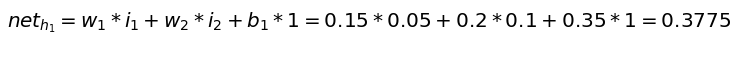

Итоговые значения:
net_h1=0.3775
net_h2=0.3925
1.2. Находим выходные значения каждого нейрона.Формула для первого нейрона: : 


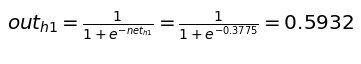

Итоговые значения:
out_h1=0.5933
out_h2=0.5969
2. Находим значения на выходном слое.
2.1. Вычисляем взвешенное значение для подачи на функцию активации. Формула для первого нейрона:


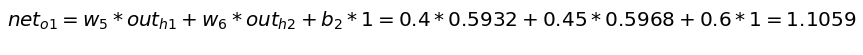

Итоговые значения:
net_o1=1.1059
net_o2=1.2249
2.2. Находим выходные значения каждого нейрона. Формула для первого нейрона: : 


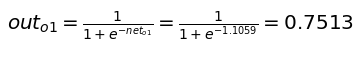

Итоговые значения:
out_o1=0.7514
out_o2=0.7729
************************************************************

Итоговое значение ошибки при первом прямом прохождении:
loss: 0.2984


In [0]:
# Создаем модель
model = simple_NN()
model.summary()
#model.show_weights()

# Делаем прямое распространение
x_input=np.array([0.05,0.1])
y_ideal=np.array([0.01,0.99])

y_output=model.forward_pass(x_input,verbose=2) #verbose=2 для вывода всей промежуточной информации

# Подсчитываем значение ошибки
print('\nИтоговое значение ошибки при первом прямом прохождении:')
loss_value = model.loss(y_ideal,y_output)
print('loss:',round(loss_value,4))



# Обратное распространение ошибки
Алгоритм обратного распространения ошибки перевзвешивает параметры сети. При этом делает это немного по-разному для весов выходных и внутренних нейронов.

Пояснительная картинка для весов выходных нейронов:
![alt text](https://matthewmazur.files.wordpress.com/2018/03/output_1_backprop-4.png)

Пояснительная картинка для весов внутренних нейронов:

![alt text](https://matthewmazur.files.wordpress.com/2015/03/nn-calculation.png)

***********************backward_pass************************
Обратное распространение ошибки!
Пройдем по всем промежуточным значениям в методе обратного распространения!
Основная идея метода обратного распространения ошибки заключается в том,
что для минимизации значения функции потерь Etotal на обучающей выборке 
мы рассматриваем функцию многих переменных Etotal(w1,w2,...,w8,b1,b2)
и стремимся ее минимизировать уменьшая значения переменных w1,w2,...,w8,b1,b2 на некоторую величину,
при этом двигаясь в направлении обратном направлению вектора градиента -
вектору, который указывает направление наискорейшего возрастания функции.

Промежуточные значения после прямого прохождения у нас сохранены. Также можно найти значение функции Etotal:


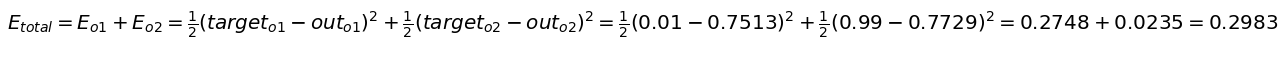


1. Пересчет значений весов выходных нейронов. Рассмотрим на примере параметра w5.
Применим правило цепочки для вычисления искомого значения частной производной - компоненты вектора градиента, отвечающей за переменную w5:


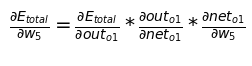

Будем последовательно находить значения каждой производной из произведения:


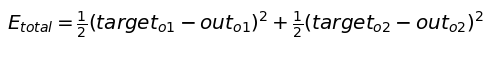

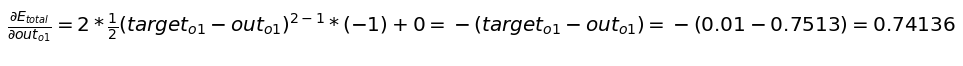

Переходим к следующей:


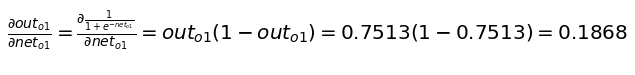

Заканчиваем нахождением:


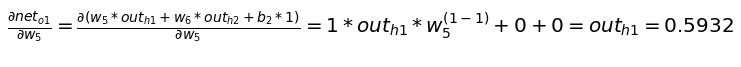

Теперь находим искомое значение производной:


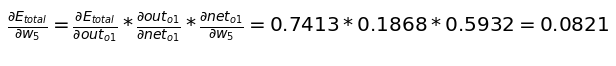

Если все выкладки объединить в одну формулу, то получим выражение:


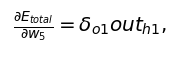

где для каждого выходного нейрона можно найти


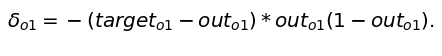

delta_o1=0.1385
delta_o2=-0.0381
Обновление веса выполняется по формуле:


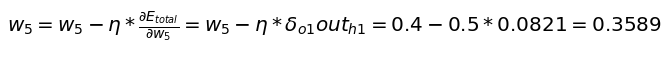

Значения обновленных весов:
[0.35891648 0.40866619]
[0.51130127 0.56137012]

2. Пересчет значений весов внутренних нейронов. Рассмотрим на примере параметра w1.
Применим правило цепочки для вычисления искомого значения частной производной - компоненты вектора градиента, отвечающей за переменную w1:


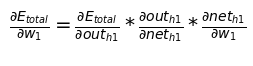

Будем последовательно находить значения каждой производной из произведения:


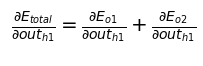

Найдем первое слагаемое:


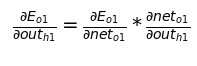

Ввиду того, что некоторые значения мы уже нашли, то можно вычислить:


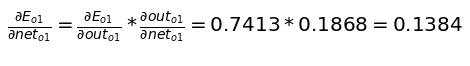

При этом дело обстоит совсем просто в случае:


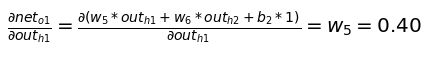

Таким образом, получаем:


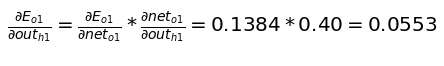

Найдя аналогичным образом значение второго слагаемого, будем иметь:


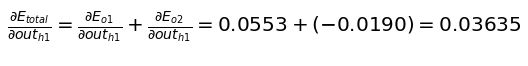

Значение второго множителя в искомом произведении производных легко можно получить:


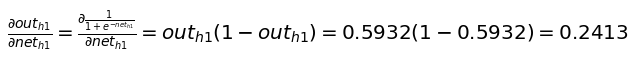

Для последней производной получаем:


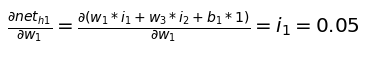

Окончательно имеем:


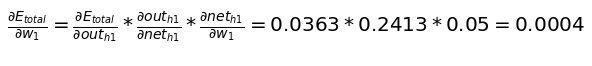

Если все выкладки объединить в одну формулу, то получим выражение:


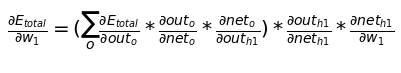

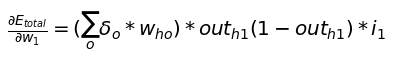

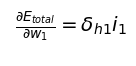

delta_h1=0.0073
delta_h2=0.0085
Обновление веса выполняется по формуле:


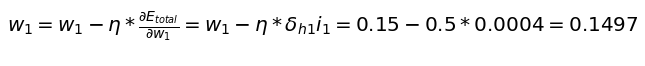

Значения обновленных весов:
[0.14981764 0.19963528]
[0.24978819 0.29957637]
************************************************************


In [0]:
# Обратное распространение ошибки
model.backward_pass(x_input,y_ideal,y_output,verbose=2)

# Обучение нейронной сети на нескольких эпохах

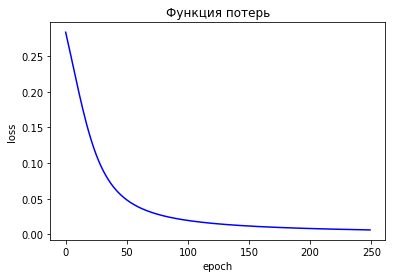

In [0]:
# Пример обучения сети на нескольких эпохах
n_epochs = 250 # количество эпох
history_loss = [] # логи функции потерь

for epoch in range(n_epochs):
  model.backward_pass(x_input,y_ideal,y_output,verbose=0)
  y_output=model.forward_pass(x_input,verbose=0)
  loss_value = model.loss(y_ideal,y_output)
  history_loss.append(loss_value)
  #print('epoch:{0} \t loss:{1}'.format(epoch,round(loss_value,4)))

plt.title('Функция потерь')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(history_loss,color='b')
plt.show()